准备20类新闻数据样本，解压缩到news20文件夹

In [1]:
from os.path import isfile, isdir, join
import tarfile
import gzip

news20 = "20news-bydate.tar.gz"
news20_path = 'news20'

models_path = 'models'

temp_path = 'temp'

if not isdir(news20_path):
    gz = gzip.GzipFile(news20)
    tarfilename = news20.replace('.gz', '')
    open(tarfilename, 'wb').write(gz.read())
    
    with tarfile.TarFile(tarfilename) as tarf:
        tarf.extractall(news20_path)
        tarf.close()
    
    gz.close()

得到训练数据和测试数据

In [2]:
import os
assert isdir(news20_path), "The news20 is not availaible"

train_path = news20_path + '/20news-bydate-train'
test_path = news20_path + '/20news-bydate-test'

def get_x_y():
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    
    for foldername in os.listdir(train_path):
        folder_path = join(train_path, foldername)
        
        for filename in os.listdir(folder_path):
            f = open(folder_path + '/' + filename, 'rb').read()
            train_x.append(f)
            train_y.append(foldername)
            
    for foldername in os.listdir(test_path):   
        folder_path = join(test_path, foldername)
        
        for filename in os.listdir(folder_path):
            f = open(folder_path + '/' + filename, 'rb').read()
            test_x.append(f)
            test_y.append(foldername)
            
    return train_x, train_y, test_x, test_y

In [3]:
train_x, train_y, test_x, test_y = get_x_y()
print(test_x[:1])
print(train_y[:1])
print("训练集一共有文档{}".format(len(train_x)))
print("测试集一共有文档{}".format(len(test_x)))

[b"From: mattf@cac.washington.edu (Matthew Freedman)\nSubject: Non-Roman Font Availability\nArticle-I.D.: shelley.1rmgleINNa0g\nDistribution: world\nOrganization: U.W. Information Systems\nLines: 16\nNNTP-Posting-Host: elvis.cac.washington.edu\n\nCan anybody tell me anything about the availibility of non-Roman fonts\nfor X-Windows? Especially Unicode and/or han idiographic fonts.\n\nAlso, how about conversion tools for getting PC/Macintosh fonts into a\nformat suitable for X? I would assume it is not too difficult for\nbitmap fonts.\n\nThe FAQ's for this group and comp.fonts are not very helpful on these\nquestions. \n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-\n= Matthew M. Freedman                                                 =\n= U. of Washington Information Systems       mattf@cac.washington.edu =\n= 4545 15th Ave. NE; 3rd Floor               (206) 543-5593           =\n= Seattle, WA  98105                                                  =\n-=-=-=-

去掉数字，非字符以及停用词，并且全部转换为小写

In [4]:
import re
def new_corpus(corpus):
    stoplist = 'for of the and to in'.split()
    stoplist.append('')
    new_corpus = [word for word in re.split(r'\W+', corpus.lower()) if word not in stoplist and not re.match(r'[0-9]+', word)]
    return new_corpus

In [5]:
def get_new_x_y():
    train_x, train_y, test_x, test_y = get_x_y()
    new_train_x = [new_corpus(x.decode('gbk', 'ignore')) for x in train_x]
    new_test_x = [new_corpus(x.decode('gbk', 'ignore')) for x in test_x]
    return new_train_x, new_test_x

new_train_x, new_test_x = get_new_x_y()
print(new_train_x[0])
print(new_test_x[0])

['from', 'afielden', 'cbnewsb', 'cb', 'att', 'com', 'andrew', 'j', 'fielden', 'subject', 'x', 'benchmarks', 'keywords', 'benchmark', 'organization', 'at', 't', 'lines', 'we', 'are', 'process', 'evaluating', 'x', 'terminals', 'this', 'includes', 'running', 'xremote', 'over', 'a', 'serial', 'line', 'i', 'would', 'like', 'run', 'some', 'x', 'benchmarks', 'determine', 'comparative', 'performance', 'has', 'anyone', 'written', 'any', 'such', 'benchmarks', 'or', 'know', 'any', 'useful', 'programs', 'on', 'net', 'i', 'heard', 'a', 'program', 'called', 'xstone', 'but', 'i', 'couldn', 't', 'locate', 'it', 'using', 'archie', 'please', 'reply', 'afielden', 'mlsma', 'att', 'com', 'as', 'i', 'don', 't', 'get', 'read', 'this', 'newsgroup', 'much', 'thanks', 'advance', 'any', 'help', 'andrew', 'fielden', 'at', 't', 'network', 'systems', 'uk', 'tel', 'information', 'systems', 'group', 'sun', 'support', 'email', 'afielden', 'mlsma', 'att', 'com']
['from', 'mattf', 'cac', 'washington', 'edu', 'matthew', 

进行one-hot编码

In [6]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(train_y)

train_y_lb = lb.transform(train_y)
test_y_lb = lb.transform(test_y)

le = preprocessing.LabelEncoder() 
le.fit(train_y)
train_y_le = le.transform(train_y)
test_y_le = le.transform(test_y)

print(test_y_lb[-2:])
print(test_y_le[:3])
print(train_y_le[:3])

[[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]]
[5 5 5]
[5 5 5]


训练集、测试集数据分布

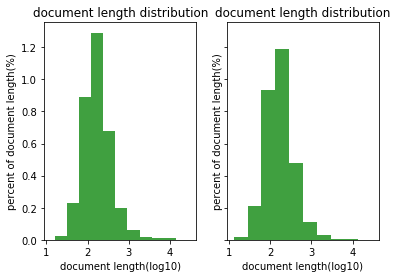

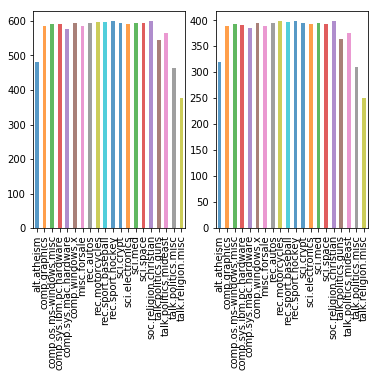

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display # 使得我们可以对DataFrame使用display()函数
from pandas import Series, DataFrame
import math

# 设置以内联的形式显示matplotlib绘制的图片（在notebook中显示更美观）
%matplotlib inline
def distribution():
    train_x, train_y, test_x, test_y = get_x_y()
    new_train_x, new_test_x = get_new_x_y()
    
    train_x_len = [len(doc) for doc in new_train_x]
    test_x_len = [len(doc) for doc in new_test_x]
    
    train_y_type = {}
    test_y_type = {}
    for doc in train_y:
        if doc not in train_y_type:
            train_y_type[doc] = 1
        else:
            train_y_type[doc] += 1
            
    for doc in test_y:
        if doc not in test_y_type:
            test_y_type[doc] = 1
        else:
            test_y_type[doc] += 1
    
     #文档长度
    fig, axe = plt.subplots(1, 2, sharex=True, sharey=True)
    for i in range(2):
        axe[i].set_title("document length distribution")
        axe[i].set_xlabel("document length(log10)")
        axe[i].set_ylabel("percent of document length(%)")
        
    axe[0].hist(np.log10(Series(train_x_len)), normed = True, alpha = 0.75,color = 'g')    
    axe[1].hist(np.log10(Series(test_x_len)), normed = True, alpha = 0.75,color = 'g')

    fig1, axe1 = plt.subplots(1, 2, sharex=True, sharey=True)        
    plt.subplot(121)
    Series(train_y_type).plot(alpha = 0.75, kind = 'bar')
    
    plt.subplot(122)
    Series(test_y_type).plot(alpha = 0.75, kind = 'bar')

distribution()

将训练集按2:8拆成验证集和训练集

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
new_train_x, train_y, test_size=0.2)

y_train_lb = lb.transform(y_train)
y_val_lb = lb.transform(y_val)
y_train_le = le.transform(y_train)
y_val_le = le.transform(y_val)

print(y_train_lb[:3])

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]]


生成词典

In [9]:
reflesh = False
from gensim.models import TfidfModel
from gensim import corpora
def make_dictionary():
    new_train_x, new_test_x = get_new_x_y()
    
    #创建字典
    assert isdir(temp_path), os.mkdir(temp_path)
    if isfile(temp_path + '/20news.dict') and (reflesh == False):
        print("loading dictionary")
        dictionary = corpora.Dictionary.load(temp_path + '/20news.dict')
    else:
        dictionary = corpora.Dictionary(new_train_x)
        dictionary.save(temp_path + '/20news.dict')
    return dictionary
dictionary = make_dictionary()
print("字典共有单词{}个".format(len(dictionary)))

loading dictionary
字典共有单词107010个


生成词袋子

In [10]:
def get_bow_x_y():
    bow_train_x = [ dictionary.doc2bow(doc) for doc in new_train_x]
    bow_test_x = [dictionary.doc2bow(doc) for doc in new_test_x]
    bow_x_train = [dictionary.doc2bow(doc) for doc in x_train]
    bow_x_val = [dictionary.doc2bow(doc) for doc in x_val]
    
    return bow_train_x, bow_test_x, bow_x_train, bow_x_val

In [11]:
#测试
bow_train_x, bow_test_x, bow_x_train, bow_x_val= get_bow_x_y()
print(bow_train_x[1][:10])
print(bow_test_x[0][:5])
print(bow_x_train[0])

[(0, 6), (4, 1), (5, 2), (9, 3), (13, 1), (17, 4), (21, 1), (22, 1), (25, 1), (30, 3)]
[(0, 1), (7, 1), (25, 1), (27, 1), (31, 2)]
[(0, 30), (4, 3), (7, 11), (8, 9), (9, 22), (13, 18), (14, 5), (21, 2), (25, 15), (26, 5), (27, 3), (28, 5), (29, 1), (30, 1), (31, 68), (34, 18), (37, 4), (38, 1), (40, 1), (43, 2), (47, 31), (48, 5), (49, 1), (50, 2), (56, 4), (61, 4), (62, 1), (65, 1), (67, 17), (75, 41), (76, 8), (77, 1), (81, 3), (82, 3), (83, 6), (84, 2), (90, 16), (93, 5), (97, 3), (99, 5), (103, 4), (106, 1), (109, 4), (116, 2), (119, 6), (120, 1), (123, 6), (135, 15), (137, 18), (145, 1), (157, 1), (166, 10), (167, 13), (169, 4), (173, 9), (179, 6), (180, 2), (181, 4), (183, 13), (184, 2), (188, 2), (190, 5), (206, 2), (209, 2), (212, 1), (222, 1), (229, 3), (230, 3), (245, 1), (246, 5), (250, 3), (255, 1), (260, 1), (261, 1), (264, 1), (265, 41), (275, 3), (281, 42), (284, 2), (285, 14), (286, 6), (291, 1), (292, 6), (301, 1), (305, 5), (313, 4), (317, 1), (318, 50), (322, 1), (32

生成tfidf模型

In [12]:
tfidf_model = True
reflesh == False
if tfidf_model == True:
    if isfile(models_path + '/news20.tfidf_model') and (reflesh == False):
        tfidf = TfidfModel.load(models_path + '/news20.tfidf_model')
    else:
        tfidf = TfidfModel(bow_x_train)
        tfidf.save(models_path + '/news20.tfidf_model')
    #测试
    print(tfidf[bow_x_val[1]])

[(0, 0.014779633588242457), (4, 0.0287460826966642), (7, 0.018347744445060897), (13, 0.018838397671037847), (31, 0.01454616459833816), (40, 8.243039588854396e-05), (47, 0.013988245131503171), (49, 0.001146508846542632), (67, 0.035307068432019174), (71, 0.07259638296125336), (72, 0.08403335489434896), (93, 0.022662867858653887), (103, 0.08467269000068807), (123, 0.01585055656129969), (148, 0.010725264179276354), (157, 0.02891058746219916), (181, 0.09435365224821175), (188, 0.0314095215244517), (204, 0.02438212330097529), (208, 0.024755228234037818), (213, 0.023056550946465103), (283, 0.026497064114131427), (305, 0.034863269983278676), (402, 0.03787263699535644), (420, 0.06541724236350498), (423, 0.030859616718826925), (437, 0.03305111041580294), (468, 0.06399408613376326), (493, 0.040698628220501666), (571, 0.02646515536472056), (744, 0.08158474710668752), (879, 0.07285443999368267), (1006, 0.10881160811928077), (1015, 0.08427214005962949), (1019, 0.0891626469605082), (1081, 0.134438801

In [13]:
if tfidf_model == True:
    tfidf_train_x = [tfidf[x] for x in bow_train_x]
    tfidf_test_x  = [tfidf[x] for x in bow_test_x]
    
    tfidf_x_train = [tfidf[x] for x in bow_x_train]
    tfidf_x_val = [tfidf[x] for x in bow_x_val]   

In [14]:
print(tfidf_x_val[0])

[(0, 0.010940845536619908), (4, 0.008511887623988256), (5, 0.014390434101620948), (8, 0.006661137953839601), (9, 0.020513008912391825), (19, 0.030799162447278598), (26, 0.011136238424417615), (30, 0.036601814684047086), (31, 0.015793091033235465), (34, 0.011189180508555262), (36, 0.021108880153382078), (37, 0.02099154841435474), (40, 2.440813497992095e-05), (48, 0.011261578272341836), (49, 0.0003394881509476679), (61, 0.01981863637054047), (63, 0.0160941880892295), (67, 0.01568195232009917), (71, 0.017196979781760983), (76, 0.03264534547884898), (81, 0.02529902260822818), (83, 0.007539568327453713), (90, 0.014264104644020734), (93, 0.02013183359476064), (104, 0.012283147401450676), (105, 0.018992881357315108), (108, 0.007115488008964714), (114, 0.0655625994910856), (116, 0.018021913387041025), (123, 0.02581394714129518), (148, 0.0031758150978317763), (157, 0.01712119694488178), (166, 0.013334485561103039), (169, 0.01316469778884457), (173, 0.022209898014220752), (180, 0.011262562902480

tfidf相似性检测

In [15]:
if tfidf_model == True:
    #TFIDF相似性检测
    nb_feature = len(dictionary)
    from gensim.similarities.docsim import Similarity
    index_tfidf = Similarity('temp/similty_idx', 
                             tfidf_x_train, 
                             num_features=nb_feature)

    index_tfidf.num_best = 10
    print (index_tfidf[tfidf_x_train[0]])

[(0, 0.9999998211860657), (505, 0.5786049962043762), (6010, 0.5432599782943726), (594, 0.5040692090988159), (4129, 0.4994984567165375), (3456, 0.4873291254043579), (5684, 0.43764516711235046), (7043, 0.25720927119255066), (1802, 0.23871898651123047), (2346, 0.2328898012638092)]


word2vec词向量

In [16]:
from os.path import isfile, isdir
import tarfile
from zipfile import ZipFile

text8_path = 'text8'

if not isdir(text8_path):
    with ZipFile('text8.zip') as zf:
        zf.extractall(text8_path)
        zf.close()

In [17]:
import numpy
import warnings
import pandas
from gensim import corpora,models,similarities
from gensim.models.word2vec import Word2Vec
from os import mkdir

max_vocab_size = 50000
reflesh = False

def word2vec_model(size):
    model_file = models_path + "/word2vec" + str(size) + ".md"
    if isfile(model_file) and (reflesh == False):
        model = Word2Vec.load(model_file)
    else:
        model = Word2Vec(new_train_x, size=size, window=5, max_vocab_size = max_vocab_size,
                         min_count=5, workers=4)
        #检查并创建模型目录
        assert isdir(models_path), mkdir(models_path)
        #保存模型
        model.save(model_file)
    return model

def word2vec_model2(size):
    model_file = models_path + "/word2vectext" + str(size) + ".md"
    if isfile(model_file) and (reflesh == False):
        model = Word2Vec.load(model_file)
    else:
        sentences = models.word2vec.Text8Corpus(text8_path + '/text8',  max_sentence_length=1000)
        model = Word2Vec(sentences, size=size, window=5, max_vocab_size = max_vocab_size,
                         min_count=5, workers=4)
        #检查并创建模型目录
        assert isdir(models_path), mkdir(models_path)
        #保存模型
        model.save(model_file)
    return model

model_word2vec = True
#使用20组新闻样本训练的word2vec模型
# if model_word2vec == True:
#     model = word2vec_model(200)
#     #使用模型实例200纬度
#     model_word2vec200 = model.wv

#使用text8训练word2vec模型
if model_word2vec == True:
    model = word2vec_model2(200)
    #使用模型实例200纬度
    model_word2vec200 = model.wv

word2vec检测相似性

In [18]:
def model_test():
    try:
        print (model_word2vec200["computer"])
        
        print("The similarity of 'computer' and 'pc' is:",
              model_word2vec200.similarity('computer', 'pc'))
        
        print("The similarity of 'computer' and 'hp' is:",
              model_word2vec200.similarity('computer', 'hp'))
    except:
        pass
model_test()

[-0.9704541   0.5189756   0.6744587   0.01087062  1.0679857  -0.52487886
 -0.64980954 -0.4533574   0.56106836  1.6472147   0.19555567 -1.9471778
  0.7707421   2.0987034  -0.226309    0.5256508   1.255615    0.36819422
  1.5916296   2.262886   -0.57896924  0.28168982  1.5931888  -1.4215323
  0.20646362 -0.99576205  0.6164254  -0.6124262  -0.902483    1.3772614
 -1.01067     2.1639864  -0.04831955  0.39986974 -0.7240784  -1.1605207
 -0.91958696  0.77921253  1.3705611  -1.2327397   1.2102787  -0.45162696
  1.6618432   0.4805663   0.42414418  0.9522331   0.05192119 -0.8744376
  1.1857388   1.3332164   0.06589112  0.7241123  -0.43246517 -0.28568465
  1.3812044   0.02615357  0.980446    2.20354     0.33822533  1.6895237
  0.918058   -2.3457983   0.9654337  -2.1902282  -0.14903644 -0.30096808
  1.0672555  -0.15213037  0.49626437  0.68427944 -1.0117623  -0.23785764
  1.8554426  -2.0654829   0.12752692 -0.5877149   0.05665542 -0.12666978
  0.04559718  0.24326645 -0.16387601 -1.2972243  -0.28819

利用word2vec200词向量平均值表示文档

In [19]:
import numpy as np
from numpy import array

def average_word_vec(doc, size):
    num_word = 0
    word_vec_model = globals()["model_word2vec" + str(size)]
    sum_vec = np.zeros(len(word_vec_model['test'])) 
    for word in doc:
        try:
            word_vec = word_vec_model[word]
            num_word += 1
            sum_vec = sum_vec + word_vec
        except: pass
    return sum_vec/num_word

average_word_vec200 = True
if average_word_vec200 == True:

#     生成文档向量
    x_train_average_word_vec200= [average_word_vec(x, 200) for x in x_train]
    print (x_train_average_word_vec200[:1])
    
    x_val_average_word_vec200 = [ average_word_vec(x, 200) for x in x_val]
    print (x_val_average_word_vec200[:1])
    
    test_x_average_word_vec200 = [ average_word_vec(x, 200) for x in new_test_x]
    print (test_x_average_word_vec200[:1])

[array([-0.07998354, -0.72177639,  0.1048835 , -0.35636717, -0.08737985,
        0.55299945,  0.16822696, -0.34368943, -0.21055081,  0.74284476,
        0.48132571,  0.35950611, -0.28621166,  0.11023551,  0.12628022,
       -0.24780488,  0.20211906, -0.34610975,  0.53338657, -0.00257856,
       -0.17577102,  0.0736735 ,  0.45189972, -0.08615299, -0.11881772,
        0.253095  ,  0.00663455,  0.29833392, -0.60384475,  0.33272245,
        0.27389537,  0.07908884,  0.2600565 , -0.02438287,  0.41406304,
        0.20309591,  0.34143777, -0.17014372,  0.30544874,  0.04337316,
        0.1616682 , -0.18096707, -0.50642577,  0.06496233,  0.10249004,
       -0.05091331,  0.11897509, -0.17966712,  0.22777721,  0.26097476,
        0.23721102,  0.13545604,  0.17124161, -0.31660963,  0.08593192,
        0.32362013, -0.18843826, -0.08942551,  0.07029901,  0.19118327,
        0.18826906, -0.23097972,  0.42046281, -0.11845288, -0.24615203,
       -0.16381095, -0.12393107, -0.47557833,  0.29429314, -0.0

生成doc2vec文档向量
    
    文档标记

In [20]:
import gensim
from gensim.models.doc2vec import Doc2Vec

doc2vec_model = True
if doc2vec_model == True:
    def tag_document(docs):
        doc_num = 0
        for x in docs:
            yield gensim.models.doc2vec.TaggedDocument(x,[doc_num])
            doc_num +=1

    x_train_doc2vec = list(tag_document(x_train))
    x_val_doc2vec = list(tag_document(x_val))
    test_x_doc2vec = list(tag_document(new_test_x))
    print(x_train_doc2vec[:2])

[TaggedDocument(words=['from', 'dbd', 'urartu', 'sdpa', 'org', 'david', 'davidian', 'subject', 'treatment', 'armenians', 'azerbaijan', 'summary', 'prelude', 'events', 'today', 'organization', 's', 'd', 'p', 'a', 'center', 'regional', 'studies', 'lines', 'deposition', 'vitaly', 'nikolayevich', 'danielian', 'born', 'attended', 'grade', 'middle', 'school', 'no', 'resident', 'at', 'building', 'apartment', 'microdistrict', 'no', 'sumgait', 'azerbaijan', 'really', 'people', 'town', 'didn', 't', 'know', 'what', 'was', 'happening', 'on', 'february', 'i', 'came', 'home', 'from', 'school', 'at', 'o', 'clock', 'being', 'excused', 'leave', 'before', 'last', 'period', 'order', 'go', 'baku', 'when', 'we', 'left', 'everything', 'town', 'was', 'fine', 'life', 'was', 'same', 'as', 'usual', 'a', 'few', 'groups', 'people', 'were', 'discussing', 'things', 'soccer', 'other', 'things', 'then', 'we', 'got', 'on', 'sumgait', 'bus', 'bound', 'baku', 'my', 'first', 'cousin', 's', 'birthday', 'my', 'father', 'my

    生成doc2vec文档模型

In [21]:
reflesh = False
if doc2vec_model == True:
    if isfile(models_path + '/doc2vec200.model') and (reflesh == False):
        model_doc2vec200 = Doc2Vec.load(models_path + '/doc2vec200.model')
    else:
        #instantiate the model with 200 dimention
        model_doc2vec200 = gensim.models.doc2vec.Doc2Vec(
            size=200, min_count=2, iter=55)
        #build a vacabulary
        model_doc2vec200.build_vocab(x_train_doc2vec)
        #Time for train
        %time model_doc2vec200.train(x_train_doc2vec, \
                                     total_examples=model_doc2vec200.corpus_count, \
                                     epochs=model_doc2vec200.iter)
        model_doc2vec200.save(models_path + "/doc2vec200.model")

In [22]:
if doc2vec_model == True:
    iv = model_doc2vec200.infer_vector(x_train_doc2vec[0].words)
    print(iv)

[ 2.27263761e+00 -1.15470171e+00 -2.44008636e+00 -5.39546847e-01
 -6.62857175e-01 -3.57489079e-01  6.98517919e-01 -3.87005359e-01
 -3.83485973e-01  1.64236629e+00  1.95837414e+00  2.38276029e+00
 -2.57053542e+00  7.10057437e-01  1.15207469e+00 -6.10908449e-01
 -1.86498892e+00 -2.51980484e-01 -4.96989936e-01 -3.23460311e-01
  7.87898898e-01 -2.65188241e+00  1.23260999e+00 -1.75981426e+00
 -8.41965497e-01  2.24783039e+00  6.97231650e-01  1.14927721e+00
  5.76548919e-05  1.02474046e+00  1.36734200e+00  6.64757848e-01
  1.75399232e+00 -4.91100043e-01 -5.62069297e-01  2.63437700e+00
 -1.08000767e+00  9.33788240e-01  9.02029350e-02  1.50964427e+00
  1.99356568e+00 -7.01731384e-01 -2.20569110e+00  4.06533152e-01
 -1.71656772e-01  7.34414577e-01  1.25242901e+00  2.90023088e-01
  1.64160585e+00 -1.08704722e+00 -1.35905302e+00 -3.35636377e+00
 -2.71992266e-01  1.74750245e+00  3.03527141e+00  9.73675191e-01
 -1.89635897e+00  4.33492690e-01 -1.14912462e+00 -1.90651226e+00
  1.15490758e+00 -1.99715

    生成文档向量

In [23]:
if doc2vec_model == True:
    x_train_doc2vec200 = [model_doc2vec200.infer_vector (x.words) for x in  x_train_doc2vec]
    x_val_doc2vec200 = [model_doc2vec200.infer_vector(x.words) for x in x_val_doc2vec]
    test_x_doc2vec200 = [model_doc2vec200.infer_vector(x.words) for x in test_x_doc2vec]

定义测评函数

In [24]:
from sklearn.metrics import f1_score
def get_f1_score(clf, input_data, target_data):
    predict_data = clf.predict(input_data)
    f1_macro = f1_score(target_data, predict_data,  average = 'macro')
    f1_micro = f1_score(target_data, predict_data,  average = 'micro')
    return f1_macro, f1_micro

def get_f1_score_pure(input_data, target_data):
    f1_macro = f1_score(target_data, input_data,  average = 'macro')
    f1_micro = f1_score(target_data, input_data,  average = 'micro')
    return f1_macro, f1_micro

稀疏矩阵格式的转换

In [25]:
from scipy.sparse import csr_matrix
def sparse_gensim2matrix(corpus):
    data = []
    rows = []
    cols = []
    line_count = 0
    for doc in corpus:  # lsi_corpus_total 是之前由gensim生成的lsi向量
        for word in doc:
            rows.append(line_count)
            cols.append(word[0])
            data.append(word[1])
        line_count += 1
    return csr_matrix((data,(rows,cols)), 
                      shape = [line_count, len(dictionary)]) # 稀疏向量

def gensim2matrix(corpus):
    return sparse_gensim2matrix(corpus).toarray()

def sparse_gensim2matrix_word2vec(corpus, word2vec_size):
    data = []
    rows = []
    cols = []
    line_count = 0
    model = globals()["model_word2vec" + str(word2vec_size)]
    for doc in corpus:  # lsi_corpus_total 是之前由gensim生成的lsi向量
        for word in doc:
            try:
                data.extend(model[getwordfromid(word[0])])
            except:
                continue
            rows.append(line_count)
            cols.extend(range(word[0],word[0]+word2vec_size))
        line_count += 1
    return csr_matrix((data,(rows,cols)), 
                      shape = [line_count, len(dictionary)*word2vec_size]) # 稀疏向量

SVM

In [44]:
from sklearn import svm
linear_svc = svm.SVC(kernel='linear')

tfidf模型

In [27]:
tfidf_x_train_sparse = sparse_gensim2matrix(tfidf_x_train)
tfidf_x_val_sparse = sparse_gensim2matrix(tfidf_x_val)
tfidf_test_x_sparse = sparse_gensim2matrix(tfidf_test_x)

linear_svc.fit(tfidf_x_train_sparse, y_train_le)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [28]:
f1_macro_x_train, f1_micro_x_train = get_f1_score( linear_svc, tfidf_x_train_sparse, y_train_le)
f1_macro_x_val, f1_micro_x_val = get_f1_score(linear_svc, tfidf_x_val_sparse, y_val_le)
f1_macro_test_x, f1_micro_test_x = get_f1_score(linear_svc, tfidf_test_x_sparse, test_y_le)
print("TFIDF x_train data Macro:{}, Micro:{}, x_val data Macro:{}, Micro:{},test_x data Macro:{}, Micro:{}".format(f1_macro_x_train, f1_micro_x_train, f1_macro_x_val, f1_micro_x_val, f1_macro_test_x, f1_micro_test_x))

TFIDF x_train data Macro:0.992947240441655, Micro:0.9930394431554525, x_val data Macro:0.9194971608987638, Micro:0.9164825452938578,test_x data Macro:0.8265814495828332, Micro:0.8305894848645778


In [32]:
def get_f1_macro(clf, input_data, target_data):
    predict_data = clf.predict(input_data)
    f1_macro = f1_score(target_data, predict_data,  average = 'macro')
#     f1_micro = f1_score(target_data, predict_data,  average = 'micro')
    return f1_macro

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

# TODO：初始化分类器
clf = svm.SVC(kernel='linear')

# TODO：创建你希望调节的参数列表
# parameters = {'C':[1, 5, 10], 'kernel':('linear', 'rbf')}
parameters = {'C':[1, 2, 5]}
# scorer = make_scorer(fbeta_score, beta=0.5)

# TODO：在分类器上使用网格搜索，使用'scorer'作为评价函数
grid_obj = GridSearchCV(clf, parameters, get_f1_macro, n_jobs=-1)

tfidf_x_train_sparse = sparse_gensim2matrix(tfidf_x_train)
tfidf_x_val_sparse = sparse_gensim2matrix(tfidf_x_val)
tfidf_test_x_sparse = sparse_gensim2matrix(tfidf_test_x)

# TODO：用训练数据拟合网格搜索对象并找到最佳参数
grid_obj.fit(tfidf_x_train_sparse,  y_train_le)

# 得到estimator
best_clf = grid_obj.best_estimator_
print("最佳参数：%r" % (grid_obj.best_params_))

f1_macro_x_train, f1_micro_x_train = get_f1_score( best_clf, tfidf_x_train_sparse, y_train_le)
f1_macro_x_val, f1_micro_x_val = get_f1_score(best_clf, tfidf_x_val_sparse, y_val_le)
f1_macro_test_x, f1_micro_test_x = get_f1_score(best_clf, tfidf_test_x_sparse, test_y_le)

print("TFIDF x_train data Macro:{}, Micro:{}, x_val data Macro:{}, Micro:{},test_x data Macro:{}, Micro:{}".format(f1_macro_x_train, f1_micro_x_train, f1_macro_x_val, f1_micro_x_val, f1_macro_test_x, f1_micro_test_x))

最佳参数：{'C': 2}
TFIDF x_train data Macro:0.9969957410290817, Micro:0.9970169042094796, x_val data Macro:0.9204082511341147, Micro:0.9173663278833407,test_x data Macro:0.8261424656888107, Micro:0.8301911842804036


word2vec200词向量平均值

In [45]:
linear_svc = svm.SVC(kernel='rbf',  C=2)
def svm_on_word2vec(size):
    x_train = globals()["x_train_average_word_vec" + str(size)]
    y_train = globals()["y_train"]
    linear_svc.fit(x_train, y_train)
    f1_macro_x_train, f1_micro_x_train = get_f1_score(linear_svc, x_train, y_train)
    
    x_val = globals()["x_val_average_word_vec" + str(size)]
    y_val= globals()["y_val"]
    f1_macro_x_val, f1_micro_x_val = get_f1_score(linear_svc, x_val, y_val)
    
    test_x = globals()["test_x_average_word_vec" + str(size)]
    test_y = globals()["test_y"]    
    f1_macro_test, f1_micro_test = get_f1_score(linear_svc, test_x, test_y)
    
    print("Average Word2VEC{} F1 macro on x_train data: {} micro {}; x_val data: macro {} micro {}; test_x data: macro {}, micro {}".format(size, f1_macro_x_train, f1_micro_x_train, f1_macro_x_val, f1_micro_x_val, f1_macro_test, f1_micro_test))    
    
svm_on_word2vec(200)

Average Word2VEC200 F1 macro on x_train data: 0.5427777511251805 micro 0.5617058888520605; x_val data: macro 0.5291634146433101 micro 0.5475033141847105; test_x data: macro 0.4942809857481009, micro 0.5150026553372278


doc2vec200

In [46]:
def svm_on_doc2vec(size):
    x_train = globals()["x_train_doc2vec" + str(size)]
    y_train = globals()["y_train"]
    linear_svc.fit(x_train, y_train)
    f1_macro_x_train, f1_micro_x_train = get_f1_score(linear_svc, x_train, y_train)
    
    x_val = globals()["x_val_doc2vec" + str(size)]
    y_val= globals()["y_val"]
    f1_macro_x_val, f1_micro_x_val = get_f1_score(linear_svc, x_val, y_val)
    
    test_x = globals()["test_x_doc2vec" + str(size)]
    test_y = globals()["test_y"]    
    f1_macro_test, f1_micro_test = get_f1_score(linear_svc, test_x, test_y)
    
    print("Doc2VEC{} F1 macro on x_train data: {} micro {}; x_val data: macro {} micro {}; test_x data: macro {}, micro {}".format(size, f1_macro_x_train, f1_micro_x_train, f1_macro_x_val, f1_micro_x_val, f1_macro_test, f1_micro_test))    

svm_on_doc2vec(200)

Doc2VEC200 F1 macro on x_train data: 0.7186971009270293 micro 0.7131808639929289; x_val data: macro 0.6000686632688742 micro 0.6058329650905877; test_x data: macro 0.587465244989735, micro 0.5966542750929368


DecisionTree

    tfidf

In [52]:
from sklearn.tree import DecisionTreeClassifier
DecisionTree = DecisionTreeClassifier(max_depth=90, min_samples_split=30)

In [48]:
tfidf_x_train_sparse = sparse_gensim2matrix(tfidf_x_train)
tfidf_x_val_sparse = sparse_gensim2matrix(tfidf_x_val)
tfidf_test_x_sparse = sparse_gensim2matrix(tfidf_test_x)

DecisionTree.fit(tfidf_x_train_sparse, y_train_le)

f1_macro_x_train, f1_micro_x_train = get_f1_score( DecisionTree, tfidf_x_train_sparse, y_train_le)
f1_macro_x_val, f1_micro_x_val = get_f1_score(DecisionTree, tfidf_x_val_sparse, y_val_le)
f1_macro_test_x, f1_micro_test_x = get_f1_score(DecisionTree, tfidf_test_x_sparse, test_y_le)
print("TFIDF x_train data Macro:{}, Micro:{},  x_val data Macro:{}, Micro:{},   test_x data Macro:{}, Micro:{}".format(f1_macro_x_train, f1_micro_x_train, f1_macro_x_val, f1_micro_x_val, f1_macro_test_x, f1_micro_test_x))

TFIDF x_train data Macro:0.8024925619155846, Micro:0.783449342614076,  x_val data Macro:0.6352994059701023, Micro:0.6252761820592134,   test_x data Macro:0.5668220984433341, Micro:0.5520446096654275


In [61]:
from sklearn.model_selection import GridSearchCV

# TODO：初始化分类器
clf = DecisionTreeClassifier()

# TODO：创建你希望调节的参数列表
parameters = {'max_depth':[80, 90, 100], 'min_samples_split':[30, 40]}

# TODO：在分类器上使用网格搜索，使用'scorer'作为评价函数
grid_obj = GridSearchCV(clf, parameters, get_f1_macro, n_jobs=-1)

# TODO：用训练数据拟合网格搜索对象并找到最佳参数
grid_obj.fit(tfidf_x_train_sparse,  y_train_le)

best_clf = grid_obj.best_estimator_
print("最佳参数：%r" % (grid_obj.best_params_))

# 得到estimator
best_clf = grid_obj.best_estimator_

f1_macro_x_train, f1_micro_x_train = get_f1_score( best_clf, tfidf_x_train_sparse, y_train_le)
f1_macro_x_val, f1_micro_x_val = get_f1_score(best_clf, tfidf_x_val_sparse, y_val_le)
f1_macro_test_x, f1_micro_test_x = get_f1_score(best_clf, tfidf_test_x_sparse, test_y_le)

print("TFIDF x_train data Macro:{}, Micro:{},  x_val data Macro:{}, Micro:{},   test_x data Macro:{}, Micro:{}".format(f1_macro_x_train, f1_micro_x_train, f1_macro_x_val, f1_micro_x_val, f1_macro_test_x, f1_micro_test_x))

最佳参数：{'max_depth': 90, 'min_samples_split': 40}
TFIDF x_train data Macro:0.7891708376015011, Micro:0.7694177438957022,  x_val data Macro:0.6273071247577596, Micro:0.618647812638091,   test_x data Macro:0.5710434271262865, Micro:0.5557620817843866


    word2vec200词向量平均值

In [42]:
def Dtree_on_word2vec(size):
    x_train = globals()["x_train_average_word_vec" + str(size)]
    y_train = globals()["y_train"]
    DecisionTree.fit(x_train, y_train)
    f1_macro_x_train, f1_micro_x_train = get_f1_score(DecisionTree, x_train, y_train)
    
    x_val = globals()["x_val_average_word_vec" + str(size)]
    y_val= globals()["y_val"]
    f1_macro_x_val, f1_micro_x_val = get_f1_score(DecisionTree, x_val, y_val)
    
    test_x = globals()["test_x_average_word_vec" + str(size)]
    test_y = globals()["test_y"]    
    f1_macro_test, f1_micro_test = get_f1_score(DecisionTree, test_x, test_y)
    
    print("Average Word2VEC{} F1 macro on x_train data: {} micro {}; x_val data: macro {} micro {}; test_x data: macro {}, micro {}".format(size, f1_macro_x_train, f1_micro_x_train, f1_macro_x_val, f1_micro_x_val, f1_macro_test, f1_micro_test))    
    
Dtree_on_word2vec(200)

Average Word2VEC200 F1 macro on x_train data: 0.591846108933848 micro 0.5916473317865429; x_val data: macro 0.29985181927253146 micro 0.2969509500662837; test_x data: macro 0.2656551415014298, micro 0.2652681890600106


In [60]:
from sklearn.model_selection import GridSearchCV

# TODO：初始化分类器
clf = DecisionTreeClassifier()

# TODO：创建你希望调节的参数列表
parameters = {'max_depth':[120, 125, 130], 'min_samples_split':[35, 40, 45]}

# TODO：在分类器上使用网格搜索，使用'scorer'作为评价函数
grid_obj = GridSearchCV(clf, parameters, get_f1_macro, n_jobs=-1)

x_train = globals()["x_train_average_word_vec" + str(200)]
y_train = globals()["y_train"]

x_val = globals()["x_val_average_word_vec" + str(200)]
y_val= globals()["y_val"]
    
test_x = globals()["test_x_average_word_vec" + str(200)]
test_y = globals()["test_y"]    

# TODO：用训练数据拟合网格搜索对象并找到最佳参数
grid_obj.fit(x_train,  y_train)

best_clf = grid_obj.best_estimator_
print("最佳参数：%r" % (grid_obj.best_params_))

# 得到estimator
best_clf = grid_obj.best_estimator_

f1_macro_x_train, f1_micro_x_train = get_f1_score( best_clf, x_train, y_train)
f1_macro_x_val, f1_micro_x_val = get_f1_score(best_clf, x_val, y_val)
f1_macro_test_x, f1_micro_test_x = get_f1_score(best_clf, test_x, test_y)

print("Average Word2VEC x_train data Macro:{}, Micro:{},  x_val data Macro:{}, Micro:{},   test_x data Macro:{}, Micro:{}".format(f1_macro_x_train, f1_micro_x_train, f1_macro_x_val, f1_micro_x_val, f1_macro_test_x, f1_micro_test_x))

最佳参数：{'max_depth': 120, 'min_samples_split': 40}
Average Word2VEC x_train data Macro:0.5468149705783228, Micro:0.546237984753066,  x_val data Macro:0.29841595778535746, Micro:0.2969509500662837,   test_x data Macro:0.268312086344151, Micro:0.2696494954859267


    doc2vec200

In [43]:
def Dtree_on_doc2vec(size):
    x_train = globals()["x_train_doc2vec" + str(size)]
    y_train = globals()["y_train"]
    DecisionTree.fit(x_train, y_train)
    f1_macro_x_train, f1_micro_x_train = get_f1_score(DecisionTree, x_train, y_train)
    
    x_val = globals()["x_val_doc2vec" + str(size)]
    y_val= globals()["y_val"]
    f1_macro_x_val, f1_micro_x_val = get_f1_score(DecisionTree, x_val, y_val)
    
    test_x = globals()["test_x_doc2vec" + str(size)]
    test_y = globals()["test_y"]    
    f1_macro_test, f1_micro_test = get_f1_score(DecisionTree, test_x, test_y)
    
    print("Doc2VEC{} F1 macro on x_train data: {} micro {}; x_val data: macro {} micro {}; test_x data: macro {}, micro {}".format(size, f1_macro_x_train, f1_micro_x_train, f1_macro_x_val, f1_micro_x_val, f1_macro_test, f1_micro_test))    

Dtree_on_doc2vec(200)

Doc2VEC200 F1 macro on x_train data: 0.4741194130854792 micro 0.4768533863661474; x_val data: macro 0.1482283533190964 micro 0.15112682280159082; test_x data: macro 0.16261841821368972, micro 0.16728624535315986


In [63]:
from sklearn.model_selection import GridSearchCV

# TODO：初始化分类器
clf = DecisionTreeClassifier()

# TODO：创建你希望调节的参数列表
parameters = {'max_depth':[120, 125, 130], 'min_samples_split':[40, 45, 50]}

# TODO：在分类器上使用网格搜索，使用'scorer'作为评价函数
grid_obj = GridSearchCV(clf, parameters, get_f1_macro, n_jobs=-1)

x_train = globals()["x_train_doc2vec" + str(200)]
y_train = globals()["y_train"]

x_val = globals()["x_val_doc2vec" + str(200)]
y_val= globals()["y_val"]
    
test_x = globals()["test_x_doc2vec" + str(200)]
test_y = globals()["test_y"]    

# TODO：用训练数据拟合网格搜索对象并找到最佳参数
grid_obj.fit(x_train,  y_train)

best_clf = grid_obj.best_estimator_
print("最佳参数：%r" % (grid_obj.best_params_))

# 得到estimator
best_clf = grid_obj.best_estimator_

f1_macro_x_train, f1_micro_x_train = get_f1_score( best_clf, x_train, y_train)
f1_macro_x_val, f1_micro_x_val = get_f1_score(best_clf, x_val, y_val)
f1_macro_test_x, f1_micro_test_x = get_f1_score(best_clf, test_x, test_y)

print("Average Word2VEC x_train data Macro:{}, Micro:{},  x_val data Macro:{}, Micro:{},   test_x data Macro:{}, Micro:{}".format(f1_macro_x_train, f1_micro_x_train, f1_macro_x_val, f1_micro_x_val, f1_macro_test_x, f1_micro_test_x))

最佳参数：{'max_depth': 125, 'min_samples_split': 45}
Average Word2VEC x_train data Macro:0.4125389138279867, Micro:0.4179648657606894,  x_val data Macro:0.15339324536015364, Micro:0.1581970835174547,   test_x data Macro:0.16844888646365214, Micro:0.1737918215613383


CNN

In [37]:
import tensorflow as tf

def neural_net_feature_input(feature_shape):
    """
    Return a Tensor for a batch of feature input
    : feature_shape: Shape of the features
    : return: Tensor for feature input.
    """

    x = tf.placeholder(tf.float32, shape= ([None] + list(feature_shape)), name='x')
    return x


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    
    y = tf.placeholder(tf.float32, shape=[None, n_classes],name='y')
    return y


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    keep_prob = tf.placeholder(tf.float32,name='keep_prob')
    return keep_prob

In [38]:
def conv1d_conn(x_tensor, conv_num_outputs, conv_ksize, conv_strides):
    """
    Apply 1d convolution to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 1-D Tuple for the convolutional layer
    :param conv_strides: Stride 1-D Tuple for convolution
    : return: A tensor that represents convolution of x_tensor
    """
    conv_depth = x_tensor.get_shape()[1].value
    F_W = tf.Variable(tf.truncated_normal(list(conv_ksize) + conv_depth + conv_num_outputs, stddev=0.05))
    F_b = tf.Variable(tf.zeros([conv_num_outputs]))
    padding = 'SAME'
    x_tensor = tf.nn.conv1d(x_tensor, F_W, [1 + list(conv_strides) + 1], padding) 
    x_tensor = tf.nn.bias_add(x_tensor, F_b)
    x_tensor = tf.nn.relu(x_tensor)
    return x_tensor

In [39]:
def conv1d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply 1d convolution to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 1-D Tuple for the convolutional layer
    :param conv_strides: Stride 1-D Tuple for convolution
    : return: A tensor that represents convolution of x_tensor
    """
    conv_depth = x_tensor.get_shape()[1].value
    F_W = tf.Variable(tf.truncated_normal(list(conv_ksize) + conv_depth + conv_num_outputs, stddev=0.05))
    F_b = tf.Variable(tf.zeros([conv_num_outputs]))
    padding = 'SAME'
    x_tensor = tf.nn.conv1d(x_tensor, F_W, [1 + list(conv_strides) + 1], padding) 
    x_tensor = tf.nn.bias_add(x_tensor, F_b)
    x_tensor = tf.nn.relu(x_tensor)
    x_tensor = tf.nn.max_pool(x_tensor, [1 + list(pool_ksize) + 1], [1 + list(pool_strides) + 1], padding) 
    return x_tensor

In [40]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    num_inputs = x_tensor.get_shape()[1].value
    f_weight = tf.Variable(tf.truncated_normal([num_inputs, num_outputs], stddev=0.05))
    f_bias = tf.Variable(tf.zeros([num_outputs]))
    fc1 = tf.add(tf.matmul(x_tensor, f_weight),  f_bias)
    fc1 = tf.nn.relu(fc1)
    return fc1

In [41]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    num_inputs = x_tensor.get_shape()[1].value
    f_weight = tf.Variable(tf.truncated_normal([num_inputs, num_outputs],  stddev=0.05))
    f_bias = tf.Variable(tf.zeros([num_outputs]))
    out = tf.add(tf.matmul(x_tensor, f_weight), f_bias)
    return out

In [42]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    
    # TODO: Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputsb
    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
    fc1 = fully_conn(conv1, 512)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    fc2 = fully_conn(fc1, 1024)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # TODO: Apply an Output Layer
    #    Set this to the number of classes
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    out = output(fc2, 20)
    
    # TODO: return output
    return out

In [43]:
def full_net(x_size, y_size):
# Remove previous weights, bias, inputs, etc..
    tf.reset_default_graph()

# Inputs
    x = neural_net_feature_input(x_size)
    y = neural_net_label_input(y_size)
    keep_prob = neural_net_keep_prob_input()

    # Model

    fc1 = fully_conn(x, y_size * 50)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    fc2 = fully_conn(fc1, y_size * 50)
    fc2 = tf.nn.dropout(fc2, keep_prob)
    out = output(fc2,y_size )
    # Name logits Tensor, so that is can be loaded from disk after training
    logits = tf.identity(out, name='logits')

    # Loss and Optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
    optimizer = tf.train.AdamOptimizer().minimize(cost)

    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    
    y_pred = tf.argmax(logits, 1, name = "pred")

    arg_prediction = tf.argmax(logits, 1)
    arg_y = tf.argmax(y, 1)
    TP = tf.count_nonzero(arg_prediction * arg_y, dtype=tf.float32)
    TN = tf.count_nonzero((arg_prediction - 1) * (arg_y - 1), dtype=tf.float32)
    
    FN = tf.count_nonzero( (arg_prediction - 1) * arg_y, dtype=tf.float32)
    FP = tf.count_nonzero( arg_prediction * (arg_y - 1), dtype=tf.float32)
    
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
   
    f1 = 2 * precision * recall / (precision + recall)
    f1_macro = tf.reduce_mean(tf.cast(f1, tf.float32), name = 'tf_macro')
    
    return tf, x, y, keep_prob, optimizer, cost, accuracy, f1_macro

In [44]:
def print_stats(session, feature_batch, label_batch, x, y, 
                keep_prob, cost, accuracy):
    loss = session.run(cost, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: 1.})
    valid_acc = session.run(accuracy, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: 1.})
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(
                loss,
                valid_acc))

In [45]:
#准备批输入
import random
def load_preprocess_training_batch(corpus, label, batch_size):
    c = list(zip(corpus, label))
    random.shuffle(c)
    temp = list(zip(*c))
    corpus = list(temp[0])
    label = list(temp[1])
    for start in range(0, len(corpus), batch_size):
        #ignore the last batch in case it's less than batch_size
        if start + batch_size <= len(corpus):
            batch_end = start + batch_size
            yield corpus[start:batch_end], label[start:batch_end]
#测试            
[print(e) for i, e in load_preprocess_training_batch(x_train[:20], y_train[:20], 10)]

['comp.sys.mac.hardware', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 'comp.sys.mac.hardware', 'alt.atheism', 'comp.windows.x', 'sci.electronics', 'comp.windows.x', 'alt.atheism', 'comp.os.ms-windows.misc']
['talk.politics.misc', 'sci.electronics', 'talk.politics.misc', 'comp.sys.ibm.pc.hardware', 'comp.graphics', 'talk.politics.misc', 'rec.autos', 'misc.forsale', 'comp.sys.mac.hardware', 'talk.politics.mideast']


[None, None]

In [46]:
def training_full_net(corpus, labels, x_size, y_size, model_path):
    tf, x, y, keep_prob, optimizer, cost, accuracy, f1_macro = full_net(x_size,y_size)
    save_model_full_net_path = model_path
    epochs = 20
    keep_probability = 0.75 
    batch_size = 36
    print('Checking the Training on a Single Batch...')
    print(tf)
    with tf.Session() as sess:
        # Initializing the variables
        sess.run(tf.global_variables_initializer())

        # Training cycle
        for epoch in range(epochs):
            batch_i = 0
            print("Epoch{} start:".format(epoch))
            for batch_features, batch_labels in load_preprocess_training_batch(
                corpus, labels, batch_size):
                sess.run(optimizer, 
                         feed_dict = {x: batch_features , y: batch_labels, 
                                      keep_prob: keep_probability})
                if batch_i % 20 == 0:
                    print('Epoch {:>2},  Batch {}:  '.format(
                        epoch, batch_i), end='')
                    print_stats(sess, batch_features, batch_labels, x, y, 
                keep_prob,cost, accuracy)
                batch_i +=1
        #保存模型
        saver = tf.train.Saver()
        save_path = saver.save(sess, save_model_full_net_path)

In [47]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import random

#模型验证            
def test_model(model_path, x_train, y_train, 
               x_val, y_val, test_x, test_y):
    """
    Test the saved model against the test dataset
    """
    batch_size = 128
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(model_path + '.meta')
        loader.restore(sess, model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        loaded_pred = loaded_graph.get_tensor_by_name('pred:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        y_output = []
        y_target = []
        for train_feature_batch, train_label_batch in load_preprocess_training_batch(x_train, y_train, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, 
                           loaded_y: train_label_batch, 
                           loaded_keep_prob: 1.0})
            
            y_output += sess.run(
                    loaded_pred,
                    feed_dict={loaded_x: train_feature_batch,
                               loaded_keep_prob: 1.0}).tolist()
            
            y_target += train_label_batch
            test_batch_count += 1

        print("batch output len:{} output:{}".format(
            len(y_output),y_output[:100]))
        print('x_train Testing Accuracy: {}\n'.format(
                        test_batch_acc_total/test_batch_count))
        y_target = [np.argmax(x) for x in y_target]

        f1_macro, f1_micro = get_f1_score_pure(
            y_target[:len(y_output)], y_output)
        print('x_train Testing F1 Macro {}    F1 Micro {}'.format(f1_macro, f1_micro))

        test_batch_acc_total = 0
        test_batch_count = 0
        y_output = []
        y_target = []
        for train_feature_batch, train_label_batch in load_preprocess_training_batch(x_val, y_val, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, 
                           loaded_y: train_label_batch, 
                           loaded_keep_prob: 1.0})
            
            y_output += sess.run(
                loaded_pred,
                feed_dict={loaded_x: train_feature_batch, 
                           #loaded_y: train_label_batch, 
                           loaded_keep_prob: 1.0}).tolist()
            
            y_target += train_label_batch
            test_batch_count += 1

        print('x_val Testing Accuracy: {}\n'.format(
            test_batch_acc_total/test_batch_count))
        y_target = [np.argmax(x) for x in y_target]
        f1_macro, f1_micro = get_f1_score_pure(
            y_target[:len(y_output)], y_output)
        print('x_val Testing F1 Macro {}    F1 Micro {}'.format(f1_macro, f1_micro))

        test_batch_acc_total = 0
        test_batch_count = 0
        y_output = []
        y_target = []
        for train_feature_batch, train_label_batch in load_preprocess_training_batch(test_x, test_y, batch_size):

            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, 
                           loaded_y: train_label_batch, 
                           loaded_keep_prob: 1.0})
            
            y_output += sess.run(
                    loaded_pred,
                    feed_dict={loaded_x: train_feature_batch, 
                               #loaded_y: train_label_batch,
                               loaded_keep_prob: 1.0}).tolist()
            
            y_target += train_label_batch
            test_batch_count += 1
            
        print('Test _X Testing Accuracy: {}\n'.format(
            test_batch_acc_total/test_batch_count))
        print("test:{}".format(y_output[:10]))
        #test_y = [np.argmax(x) for x in test_y]
        y_target = [np.argmax(x) for x in y_target]
        f1_macro, f1_micro = get_f1_score_pure(
            y_target[:len(y_output)], y_output)
        print('Test _X Testing F1 Macro {}    F1 Micro {}'.format(f1_macro, f1_micro))

word2vec200词向量平均值

In [60]:
model_path = './full_net_word_vec200'
training_full_net(x_train_average_word_vec200, y_train_lb, [200], 20, model_path)

test_model (model_path, x_train_average_word_vec200, y_train_lb, x_val_average_word_vec200, y_val_lb, 
           test_x_average_word_vec200, test_y_lb)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Checking the Training on a Single Batch...
<module 'tensorflow' from '/home/chronosvv/.pyenv/versions/3.5.2/lib/python3.5/site-packages/tensorflow/__init__.py'>
Epoch0 start:
Epoch  0,  Batch 0:  Loss:     2.8167 Validation Accuracy: 0.166667
Epoch  0,  Batch 20:  Loss:     2.7955 Validation Accuracy: 0.166667
Epoch  0,  Batch 40:  Loss:     2.4896 Validation Accuracy: 0.277778
Epoch  0,  Batch 60:  Loss:     2.0984 Validation Accuracy: 0.361111
Epoch  0,  Batch 80:  Loss:     2.0346 Validation Accuracy: 0.444444
Epoch  0,  Batch 100:  Loss:     2.1312 Validation Accuracy: 0.361111
Epoch  0,  Batch 120:  Loss:     2.1923 Validation Accuracy: 0.416667
Epoch  0,  Batch 140:  Loss:     2.0776 Validation Accuracy: 0.361111
Epoch  0,  Batch 160:  Loss:     1.9663 Validation Accuracy: 0.333333
Epoch  0,  B

Epoch  8,  Batch 100:  Loss:     1.1316 Validation Accuracy: 0.500000
Epoch  8,  Batch 120:  Loss:     1.5224 Validation Accuracy: 0.416667
Epoch  8,  Batch 140:  Loss:     1.2631 Validation Accuracy: 0.500000
Epoch  8,  Batch 160:  Loss:     1.8336 Validation Accuracy: 0.472222
Epoch  8,  Batch 180:  Loss:     1.4195 Validation Accuracy: 0.527778
Epoch  8,  Batch 200:  Loss:     1.4376 Validation Accuracy: 0.444444
Epoch  8,  Batch 220:  Loss:     1.6247 Validation Accuracy: 0.361111
Epoch  8,  Batch 240:  Loss:     1.3188 Validation Accuracy: 0.583333
Epoch9 start:
Epoch  9,  Batch 0:  Loss:     1.3258 Validation Accuracy: 0.555556
Epoch  9,  Batch 20:  Loss:     1.0825 Validation Accuracy: 0.611111
Epoch  9,  Batch 40:  Loss:     1.3362 Validation Accuracy: 0.555556
Epoch  9,  Batch 60:  Loss:     1.3931 Validation Accuracy: 0.472222
Epoch  9,  Batch 80:  Loss:     1.2871 Validation Accuracy: 0.611111
Epoch  9,  Batch 100:  Loss:     1.2615 Validation Accuracy: 0.583333
Epoch  9,  B

Epoch 17,  Batch 80:  Loss:     1.3268 Validation Accuracy: 0.472222
Epoch 17,  Batch 100:  Loss:     1.2928 Validation Accuracy: 0.638889
Epoch 17,  Batch 120:  Loss:     1.1937 Validation Accuracy: 0.500000
Epoch 17,  Batch 140:  Loss:     1.1237 Validation Accuracy: 0.611111
Epoch 17,  Batch 160:  Loss:     1.0009 Validation Accuracy: 0.694444
Epoch 17,  Batch 180:  Loss:     1.1928 Validation Accuracy: 0.666667
Epoch 17,  Batch 200:  Loss:     1.2393 Validation Accuracy: 0.611111
Epoch 17,  Batch 220:  Loss:     1.2580 Validation Accuracy: 0.555556
Epoch 17,  Batch 240:  Loss:     1.0508 Validation Accuracy: 0.694444
Epoch18 start:
Epoch 18,  Batch 0:  Loss:     1.1503 Validation Accuracy: 0.638889
Epoch 18,  Batch 20:  Loss:     1.2576 Validation Accuracy: 0.638889
Epoch 18,  Batch 40:  Loss:     1.1964 Validation Accuracy: 0.500000
Epoch 18,  Batch 60:  Loss:     1.3293 Validation Accuracy: 0.388889
Epoch 18,  Batch 80:  Loss:     1.3734 Validation Accuracy: 0.555556
Epoch 18,  B

doc2vec200

In [61]:
model_path = './full_net_doc_vec200'
training_full_net(x_train_doc2vec200, y_train_lb, [200], 20, model_path)

test_model (model_path, x_train_doc2vec200, y_train_lb, x_val_doc2vec200, y_val_lb, 
           test_x_doc2vec200, test_y_lb)

Checking the Training on a Single Batch...
<module 'tensorflow' from '/home/chronosvv/.pyenv/versions/3.5.2/lib/python3.5/site-packages/tensorflow/__init__.py'>
Epoch0 start:
Epoch  0,  Batch 0:  Loss:     2.6269 Validation Accuracy: 0.305556
Epoch  0,  Batch 20:  Loss:     2.6958 Validation Accuracy: 0.277778
Epoch  0,  Batch 40:  Loss:     2.5916 Validation Accuracy: 0.361111
Epoch  0,  Batch 60:  Loss:     2.2536 Validation Accuracy: 0.500000
Epoch  0,  Batch 80:  Loss:     2.2695 Validation Accuracy: 0.388889
Epoch  0,  Batch 100:  Loss:     1.5219 Validation Accuracy: 0.444444
Epoch  0,  Batch 120:  Loss:     1.8888 Validation Accuracy: 0.500000
Epoch  0,  Batch 140:  Loss:     1.7329 Validation Accuracy: 0.444444
Epoch  0,  Batch 160:  Loss:     1.5271 Validation Accuracy: 0.583333
Epoch  0,  Batch 180:  Loss:     1.1286 Validation Accuracy: 0.638889
Epoch  0,  Batch 200:  Loss:     1.5405 Validation Accuracy: 0.611111
Epoch  0,  Batch 220:  Loss:     1.5424 Validation Accuracy: 

Epoch  8,  Batch 220:  Loss:     0.5156 Validation Accuracy: 0.888889
Epoch  8,  Batch 240:  Loss:     0.6491 Validation Accuracy: 0.805556
Epoch9 start:
Epoch  9,  Batch 0:  Loss:     0.7950 Validation Accuracy: 0.777778
Epoch  9,  Batch 20:  Loss:     0.6027 Validation Accuracy: 0.888889
Epoch  9,  Batch 40:  Loss:     1.0028 Validation Accuracy: 0.694444
Epoch  9,  Batch 60:  Loss:     0.7767 Validation Accuracy: 0.833333
Epoch  9,  Batch 80:  Loss:     0.5748 Validation Accuracy: 0.805556
Epoch  9,  Batch 100:  Loss:     0.5938 Validation Accuracy: 0.722222
Epoch  9,  Batch 120:  Loss:     0.5410 Validation Accuracy: 0.888889
Epoch  9,  Batch 140:  Loss:     0.8094 Validation Accuracy: 0.777778
Epoch  9,  Batch 160:  Loss:     0.5881 Validation Accuracy: 0.888889
Epoch  9,  Batch 180:  Loss:     0.3386 Validation Accuracy: 0.972222
Epoch  9,  Batch 200:  Loss:     0.5469 Validation Accuracy: 0.861111
Epoch  9,  Batch 220:  Loss:     0.9770 Validation Accuracy: 0.750000
Epoch  9,  B

Epoch 17,  Batch 200:  Loss:     0.3623 Validation Accuracy: 0.861111
Epoch 17,  Batch 220:  Loss:     0.1625 Validation Accuracy: 0.944444
Epoch 17,  Batch 240:  Loss:     0.3735 Validation Accuracy: 0.861111
Epoch18 start:
Epoch 18,  Batch 0:  Loss:     0.4994 Validation Accuracy: 0.833333
Epoch 18,  Batch 20:  Loss:     0.3934 Validation Accuracy: 0.916667
Epoch 18,  Batch 40:  Loss:     0.1643 Validation Accuracy: 0.972222
Epoch 18,  Batch 60:  Loss:     0.0684 Validation Accuracy: 1.000000
Epoch 18,  Batch 80:  Loss:     0.2605 Validation Accuracy: 0.972222
Epoch 18,  Batch 100:  Loss:     0.1111 Validation Accuracy: 1.000000
Epoch 18,  Batch 120:  Loss:     0.3042 Validation Accuracy: 0.916667
Epoch 18,  Batch 140:  Loss:     0.2550 Validation Accuracy: 0.944444
Epoch 18,  Batch 160:  Loss:     0.4593 Validation Accuracy: 0.861111
Epoch 18,  Batch 180:  Loss:     0.0421 Validation Accuracy: 1.000000
Epoch 18,  Batch 200:  Loss:     0.2389 Validation Accuracy: 0.916667
Epoch 18,  